# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (Inria), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [12]:
%matplotlib inline
import os
import time
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import problem
from joblib import dump, load

pd.set_option('display.max_columns', None)



# Estimator

Tree-based algorithms requires less complex preprocessing than linear-models. We will first present a machine-learning pipeline where we will use a random forest. In this pipeline, we will need to:

encode the date to numerical values (as presented in the section above);
oridinal encode the other categorical values to get numerical number;
keep numerical features as they are.
Thus, we want to perform three different processes on different columns of the original data X. In scikit-learn, we can use make_column_transformer to perform such processing.

In [20]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import xgboost as xgb

merging_keys = ['DateOfDeparture', 'Departure', 'Arrival'] # keys to merge external_data.csv and the main data


# ext_data_predictors = ["Frequency", "Delta", "Price"]
# int_data_predictors = ["WeeksToDeparture"]

# all_predictors = merging_keys + ext_data_predictors + int_data_predictors

def _merge_external_data(X):
    # filepath = os.path.join(
    #     os.path.dirname(__file__), 'external_data.csv'
    # )

    filepath = 'external_data.csv'

    X = X.copy()
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    
    # Parse date to also be of dtype datetime
    data_w = pd.read_csv(filepath)
    data_w.loc[:, "DateOfDeparture"] = pd.to_datetime(data_w['DateOfDeparture'])
    # data_w = data_w.drop(['internat_dep_month_vol', 'population_arrival', 'population_departure'], axis=1)

    X_merged = X.merge(data_w, how='left', on=['DateOfDeparture', 'Departure', 'Arrival'])


    return X_merged

def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, "DateOfDeparture"] = pd.to_datetime(X_encoded["DateOfDeparture"])
    # Encode the DateOfDeparture
    # X_encoded.loc[:, 'year'] = X_encoded["DateOfDeparture"].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    # X_encoded.loc[:, 'day'] = X_encoded["DateOfDeparture"].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded["DateOfDeparture"].dt.weekday
    # X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    # X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
    #    lambda date: (date - pd.to_datetime("1970-01-01")).days)
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["DateOfDeparture"])


def get_estimator():

    data_merger = FunctionTransformer(_merge_external_data)
    date_encoder = FunctionTransformer(_encode_dates)
    

    date_cols = ["DateOfDeparture"]

    categorical_encoder = make_pipeline(
        SimpleImputer(strategy='constant', fill_value="missing"),
        OrdinalEncoder()
    )
    

    categorical_cols = ['Arrival', 'Departure']

    preprocessor = make_column_transformer(
        (date_encoder, date_cols),
        (categorical_encoder, categorical_cols),
        remainder='passthrough',  # passthrough numerical columns as they are
    )


    regressor = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective ='reg:squarederror', n_estimators=2000,        eval_metric='rmse', learning_rate = 0.001)
#,colsample_bytree = 0.5, learning_rate = 0.05,max_depth = 8, alpha = 2, n_estimators = 2500, max_leaves=10

    return make_pipeline(data_merger, preprocessor, regressor)

In [8]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()
pipeline = get_estimator()

# Parameters Grid Search

In [9]:
param_grid = {

    'xgbregressor__max_depth': [5, 8, 10],
    'xgbregressor__n_estimators': [2000, 5000],
     'xgbregressor__colsample_bylevel' : [0.3, 0.5, 0.8],
     'xgbregressor__colsample_bynode' : [0.3, 0.5, 0.8],
     'xgbregressor__max_leaves' : [3, 5, 10, 15]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=2)


In [10]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   53.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 18.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 22.0min
[Parall

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _merge_external_data at 0x000001B3FE502EE0>)),
                                       ('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function _encode_dates at 0x000001B3FE502820>),
                                                                         ['DateOfDeparture']),
                                                                        ('pipeline',
                                                                         Pi...
                                                     subsample=None,
                                                     tree_method='gpu_hist',
    

In [16]:
df_res = pd.DataFrame(data = grid.cv_results_).sort_values("rank_test_score")
params = df_res.tail(1)["params"].values
print(params)
dump(grid, 'grid_search.joblib') 
df_res.to_excel("grid_search_save_results.xlsx", index=False)

[{'xgbregressor__colsample_bylevel': 0.3, 'xgbregressor__colsample_bynode': 0.3, 'xgbregressor__max_depth': 5, 'xgbregressor__max_leaves': 3, 'xgbregressor__n_estimators': 2000}]


# PCA Grid Search 

In [37]:
param_grid = {
    'pca__n_components': [4, 6, 8, 10, 12, 15, 16],
    'xgbregressor__max_depth': [5],
    # 'xgbregressor__n_estimators': [1000, 2000, 2500],
    'xgbregressor__alpha' : [2],
    'xgbregressor__learning_rate' : [0.01]
}

grid_pca = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=2)

In [25]:
## SAUVEGARDE PCA###

df_save = df_res_pca.copy()
df_save.head()

df_save.to_excel("grid_pca_save_result.xlsx", index=False)



In [38]:
%%time
grid_pca.fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   31.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:  4.7min finished
Wall time: 4min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _merge_external_data at 0x000001E085BAEDC0>)),
                                       ('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function _encode_dates at 0x000001E08658C820>),
                                                                         ['DateOfDeparture']),
                                                                        ('pipeline',
                                                                         Pi...
                                                     num_parallel_tree=1,
                                                     random_state=0,
       

In [39]:
df_res_pca = pd.DataFrame(data = grid_pca.cv_results_).sort_values("rank_test_score")
df_res_pca.head()
params = df_res_pca.head(1)["params"].values
print(params)

[{'pca__n_components': 16, 'xgbregressor__alpha': 2, 'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 5}]


# Score and features testing

In [51]:
merging_keys = ['DateOfDeparture', 'Departure', 'Arrival'] # keys to merge external_data.csv and the main data

categorical_cols = ['Arrival', 'Departure']
numerical_cols = ['WeeksToDeparture', 'delta', 'a_airlines', 'booking', 'Holiday']
cat_num_cols = ['DateOfDeparture'] + categorical_cols + numerical_cols
full_cols =  numerical_cols + ['month'] + ['weekday']

def _merge_external_data(X):
    filepath = 'external_data.csv'

    X = X.copy()
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    
    # Parse date to also be of dtype datetime
    data_w = pd.read_csv(filepath)
    data_w.loc[:, "DateOfDeparture"] = pd.to_datetime(data_w['DateOfDeparture'])
    # data_w = data_w.drop(['internat_dep_month_vol', 'population_arrival', 'population_departure'], axis=1)
    #data_w = data_w.fillna(0)

    X_merged = X.merge(data_w, how='left', on=['DateOfDeparture', 'Departure', 'Arrival'])
    #X_merged = X_merged.drop(columns=["density_departure", "a_airlines", "WeeksToDeparture", "population_departure", "Holiday", "density_departure"])
    X_merged = X_merged.loc[:, cat_num_cols]
    return X_merged


def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, "DateOfDeparture"] = pd.to_datetime(X_encoded["DateOfDeparture"])
    # Encode the DateOfDeparture
    # X_encoded.loc[:, 'year'] = X_encoded["DateOfDeparture"].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    # X_encoded.loc[:, 'day'] = X_encoded["DateOfDeparture"].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded["DateOfDeparture"].dt.weekday
    # X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    # X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
    #    lambda date: (date - pd.to_datetime("1970-01-01")).days)
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["DateOfDeparture"])


def get_estimator():

    data_merger = FunctionTransformer(_merge_external_data)
    date_encoder = FunctionTransformer(_encode_dates)
    

    date_cols = ["DateOfDeparture"]

    # categorical_encoder = make_pipeline(
    #     SimpleImputer(strategy='constant', fill_value="missing"),
    #     OrdinalEncoder()
    # )

    # categorical_encoder = make_pipeline(
    #     OneHotEncoder()
    # )
    

    categorical_cols = ['Arrival', 'Departure']
    # categorical_cols=[]

    preprocessor = make_column_transformer(
        (date_encoder, date_cols),
        (categorical_encoder, categorical_cols),
        remainder='passthrough',  # passthrough numerical columns as they are
    )



    regressor = xgb.XGBRegressor(objective ='reg:squarederror', 
    # colsample_bylevel=0.3, colsample_bynode=0.5,
    max_depth = 8, alpha = 2, n_estimators = 2500, max_leaves=15, eval_metric='rmse')



    return make_pipeline(data_merger, preprocessor, regressor)

In [52]:
data_train = pd.read_csv(
    os.path.join('data', 'train.csv.bz2')
)
data_test = pd.read_csv(
    os.path.join('data', 'test.csv.bz2')
) 


X_train, y_train = data_train.drop(columns=["log_PAX"]), data_train["log_PAX"]



pipeline = get_estimator()

pipeline.fit(X_train, y_train)

def process_data(X):

    data_merger = FunctionTransformer(_merge_external_data)
    date_encoder = FunctionTransformer(_encode_dates)
    date_cols = ["DateOfDeparture"]
    categorical_encoder = make_pipeline(
        SimpleImputer(strategy='constant', fill_value="missing"),
        OrdinalEncoder()
    )
    

    preprocessor = make_column_transformer(
        (date_encoder, date_cols),
        (categorical_encoder, categorical_cols),
        remainder='passthrough',  # passthrough numerical columns as they are
    )

    pipe = make_pipeline(data_merger, preprocessor)
    return pipe.fit_transform(X)

X_test, y_test = data_test.drop(columns=["log_PAX"]), data_test["log_PAX"]
X_test = process_data(X_test)




In [53]:
print(pipeline['columntransformer'].named_transformers_['pipeline']['onehotencoder'].get_feature_names())
print(pipeline[2])

['x0_ATL' 'x0_BOS' 'x0_CLT' 'x0_DEN' 'x0_DFW' 'x0_DTW' 'x0_EWR' 'x0_IAH'
 'x0_JFK' 'x0_LAS' 'x0_LAX' 'x0_LGA' 'x0_MCO' 'x0_MIA' 'x0_MSP' 'x0_ORD'
 'x0_PHL' 'x0_PHX' 'x0_SEA' 'x0_SFO' 'x1_ATL' 'x1_BOS' 'x1_CLT' 'x1_DEN'
 'x1_DFW' 'x1_DTW' 'x1_EWR' 'x1_IAH' 'x1_JFK' 'x1_LAS' 'x1_LAX' 'x1_LGA'
 'x1_MCO' 'x1_MIA' 'x1_MSP' 'x1_ORD' 'x1_PHL' 'x1_PHX' 'x1_SEA' 'x1_SFO']
XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, max_leaves=15, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2500,
             n_jobs=0, num_parallel_tree=1, random_state=0, reg_alpha=2,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [56]:
### ONE HOT ENCODING

# print(pipeline[2].get_booster().get_score(importance_type="gain"))

onehot_columns = pipeline['columntransformer'].named_transformers_['pipeline']['onehotencoder'].get_feature_names(input_features=categorical_cols)

feature_importance = pd.DataFrame(data=pipeline[2].feature_importances_, index = np.array(full_cols + list(onehot_columns)), columns=["score"])
feature_importance = feature_importance.sort_values(by = "score", ascending=False)
feature_importance.plot(kind='barh')

<AxesSubplot:>

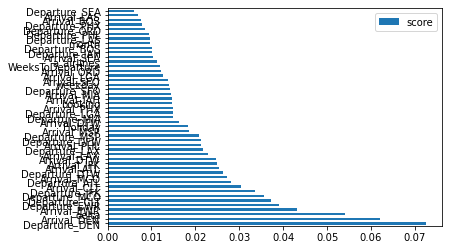

In [59]:
### CATEGORICAL ENCODING

onehot_columns = pipeline['columntransformer'].named_transformers_['pipeline']['onehotencoder'].get_feature_names(input_features=categorical_cols)

feature_importance = pd.DataFrame(data=pipeline[2].feature_importances_, index = np.array(full_cols + list(onehot_columns)), columns=["score"])
feature_importance = feature_importance.sort_values(by = "score", ascending=False)
feature_importance.plot(kind='barh')

In [23]:
col_list = ['IGNORE', 'DateOfDeparture', 'Departure', 'Arrival', 'WeeksToDeparture',
        'std_wtd', 'Flight baseline frequentation', 'weekly_volume', 'Holiday',
       'population_departure', 'density_departure', 'population_arrival',
       'density_arrival', 'distance', 'domestic_dep_month_vol',
       'internat_dep_month_vol', 'total_dep_month_vol', 'a_airlines', 'delta',
       'booking', 'weekday']

pipeline[2].get_booster().feature_names = col_list

print(len(col_list))
print(X_train.shape[1])

rename_dict = {}
for idx, k in enumerate(col_list):
    idx+=1
    name = f'f{idx}'
    rename_dict[name] = k

feature_important = pipeline[3].get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
# data = data.rename(index=rename_dict)
data = data.sort_values(by = "score", ascending=False)
data.plot(kind='barh')
plt.savefig('feature_importances.png')

IndexError: list index out of range

In [92]:
print(pipeline[3].score(X_test, y_test))
#print(pipeline[3].get_fscore())

-3.1246355990469885


AttributeError: 'XGBRegressor' object has no attribute 'get_fscore'

In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline, X, y, cv=10, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

RMSE: 0.7061 +/- 0.0538


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

merger = pipeline[0]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipeline[1:]
predictor.fit(X_train_augmented, y_train).score(X_test_augmented, y_test)

0.32270346369775726

In [8]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=10
)

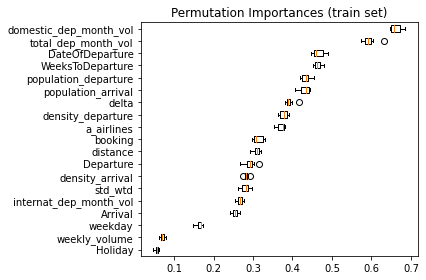

In [9]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [10]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

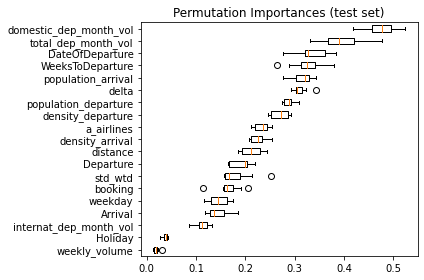

In [11]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()